# Make class of **Variable** & **Layers**
This methods is used by pytorch and keras 

In [32]:
class Variable(object):
    def __init__(self, value, origin=None):
        self.value = value
        self.origin = origin # OBJECT LAYER from below class
    def back_propagate(self, g=1):
        if (self.origin is None):
            return 
        g = self.origin.backward(g)
        for indep_var in self.origin.indep_variables:
            # Make sense because indep_variables is made from This class
            # please see return statement in __call__()
            indep_var.back_propagate(g) 
class Layer:
    def __init__(self):
        'wait definition in subclass'
    
    def __call__(self, *variables):
        self.indep_variables = [] # collections of *variables
        indep_variables_value = []
        
        for var in variables:
            if (type(var) == Variable):
                self.indep_variables.append(var)
                indep_variables_value.append(var.value)
            else:
                indep_variables_value.append(var)
        dep_variables_value = self.forward(*indep_variables_value)
        dep_variables = Variable(dep_variables_value, origin=self) # object of dependent variable
        return dep_variables
    
    # ABSTRACT FUNCTIONS
    def forward(self):
        'wait definition in subclass'
    def backward(self):
        'wait definition in subclass'

# Class of **Activation functions** & **Loss function**

In [33]:
import numpy as np

# inherited from Layer class
class Sigmoid(Layer):
    def forward(self, a):
        self.h = 1/(1+np.exp(-a))
        return self.h
    def backward(self, g):
        return g * (1-self.h) * self.h
    
class ReLu(Layer):
    def forward(self, x):
        self.filter = x > 0
        return np.where(self.filter, x, 0)
    def backward(self, g):
        return np.where(self.filter, g, 0)
    
class SoftmaxEntropy(Layer):
    def forward(self, a, Z):
        self.Z = Z
        exp_a = np.exp(a.T - a.max(1))
        self.h = (exp_a/exp_a.sum(0)).T
        return -(np.log(self.h[Z] + 1e-10)).mean()
    def backward(self, g):
        # return g * (self.h - self.Z)/len(self.Z) # OLD
        return g * (self.h - self.Z)/len(self.h)


In [34]:
def cal_onehot(z, n):
    return z[:, None] == range(n)



## A Layer with parmas like Affine we will make class Param to collects parameters & derivatives of its

In [35]:
class Param:
    def __init__(self, value):
        self.value = value
        self.g = 0

class Affine(Layer):
    # Input : m0, Output : m1, Distribution scale : sigma
    def __init__(self, m0, m1, sigma):
        self.m = m0, m1
        # self.w = np.random.normal(0, sigma, self.m)
        # self.b = np.zeros(m1)
        # self.gw, self.gb = 0, 0
        self.params = [
            Param(np.random.normal(0, sigma, self.m)),
            Param(np.zeros(m1))
        ]
    def forward(self, X):
        self.X = X
        # return np.dot(X, self.w) + self.b
        return np.dot(X, self.params[0].value) + self.params[1].value
    
    def backward(self, g):
        # self.gw += np.dot(self.X.T, g)
        # self.gb += g.sum(0)
        # return np.dot(g, self.w.T)
        self.params[0].g += np.dot(self.X.T, g)
        self.params[1].g += g.sum(0)
        return np.dot(g, self.params[0].value.T)


In [36]:

class NN_MultiLayerPerceptron:
    def __init__(self, m, sigma=1, eta=.1, active_func='relu'):
        self.m, self.eta = m, eta
        self.layers = []
        
        for i in range(len(m) - 1):
            self.layers.append(Affine(m[i], m[i+1], sigma=sigma))
            if (i<len(m) - 2):
                if active_func == 'relu':
                    self.layers.append(ReLu())
                else:
                    self.layers.append(Sigmoid())
        self.layers.append(SoftmaxEntropy())
        
    def learn(self, X, z, n_learns):
        Z = cal_onehot(z, self.m[-1])
        self.entropy = []
        for i in range(n_learns):
            entropy = self.cal_entropy(X, Z)
            entropy.back_propagate()
            self.adjust_params()
            self.entropy.append(entropy.value)
    
    def cal_entropy(self, X, Z):
        for layer in self.layers[:-1]:
            X = layer(X)
        return self.layers[-1](X, Z)
    
    def adjust_params(self):
        for layer in self.layers:
            if not hasattr(layer, 'params'):
                continue
            for param in layer.params:
                param.value -= self.eta * param.g
                param.g = 0
                
    def predict(self, X):
        for layer in self.layers[:-1]:
            # X = l.forward(X)
            X = layer(X)
        return X.value.argmax(1)

# Classify this data

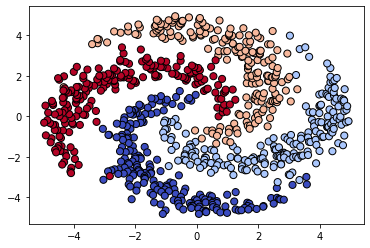

In [37]:
import matplotlib.pyplot as plt

np.random.seed(1)
r = np.tile(np.sqrt(np.linspace(0.5,25,200)),4)
t = np.random.normal(np.sqrt(r*5),0.3)
z = np.arange(4).repeat(200)
t += z*np.pi/2
X = np.array([r*np.cos(t),r*np.sin(t)]).T

plt.scatter(X[:,0],X[:,1],50,c=z,edgecolor='k',cmap='coolwarm')
plt.show()

# Use NN 2 hidden layers to classify

In [38]:
nn = NN_MultiLayerPerceptron(m=[2, 50, 4], 
                            eta=.1,
                            active_func='relu')
nn.learn(X, z, n_learns=5000)

In [39]:
mx, my = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 200),
    np.linspace(X[:,1].min(), X[:,1].max(), 200)
)
mX = np.array([mx.ravel(), my.ravel()]).T
mz = nn.predict(mX).reshape(200, -1)

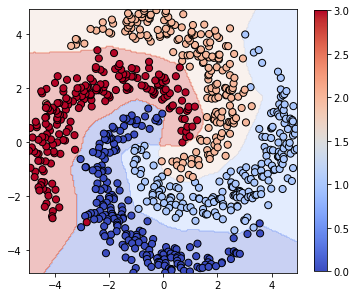

In [41]:
plt.figure(figsize=(6,6 ))
plt.axes(aspect=1, 
         xlim=(X[:,0].min(), X[:,0].max()),
        ylim=(X[:,1].min(), X[:,1].max())
        )
cm = 'coolwarm'
plt.contourf(mx, my, mz, cmap=cm, alpha=.3)
plt.scatter(X[:,0], X[:,1], 50, c=z, edgecolor='k', cmap=cm)

plt.colorbar(shrink=.8)
plt.show()

# Try 4 layers

In [44]:
nn = NN_MultiLayerPerceptron(m=[2, 50, 50, 50, 4], 
                            eta=.01,
                            active_func='relu')
nn.learn(X, z, n_learns=5000)

In [45]:
mx, my = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 200),
    np.linspace(X[:,1].min(), X[:,1].max(), 200)
)
mX = np.array([mx.ravel(), my.ravel()]).T
mz = nn.predict(mX).reshape(200, -1)

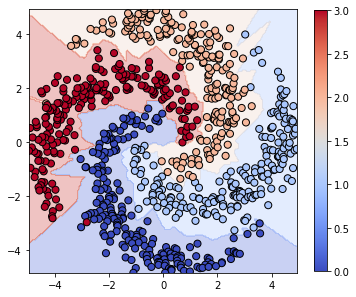

In [46]:
plt.figure(figsize=(6,6 ))
plt.axes(aspect=1, 
         xlim=(X[:,0].min(), X[:,0].max()),
        ylim=(X[:,1].min(), X[:,1].max())
        )
cm = 'coolwarm'
plt.contourf(mx, my, mz, cmap=cm, alpha=.3)
plt.scatter(X[:,0], X[:,1], 50, c=z, edgecolor='k', cmap=cm)

plt.colorbar(shrink=.8)
plt.show()

# Try More

In [52]:
nn = NN_MultiLayerPerceptron(m=[2, 50, 50, 50, 50, 50, 6], 
                            eta=.01,
                            active_func='relu')
# nn = NN_MultiLayerPerceptron(m=[2, 50, 50, 50, 50, 50, 6], 
#                             eta=.01,
#                             active_func='relu')
nn.learn(X, z, n_learns=5000)

In [53]:
mx, my = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 200),
    np.linspace(X[:,1].min(), X[:,1].max(), 200)
)
mX = np.array([mx.ravel(), my.ravel()]).T
mz = nn.predict(mX).reshape(200, -1)

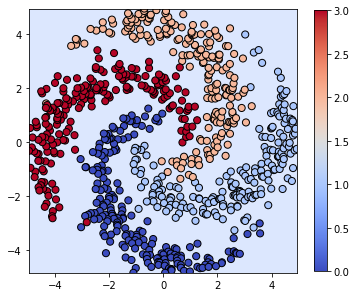

In [54]:
plt.figure(figsize=(6,6 ))
plt.axes(aspect=1, 
         xlim=(X[:,0].min(), X[:,0].max()),
        ylim=(X[:,1].min(), X[:,1].max())
        )
cm = 'coolwarm'
plt.contourf(mx, my, mz, cmap=cm, alpha=.3)
plt.scatter(X[:,0], X[:,1], 50, c=z, edgecolor='k', cmap=cm)

plt.colorbar(shrink=.8)
plt.show()

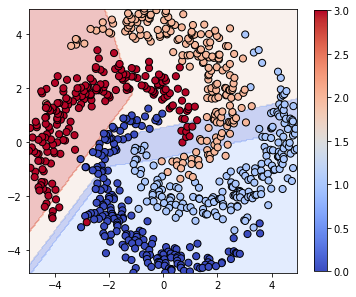

In [61]:
nn = NN_MultiLayerPerceptron(m=[2, 2, 2, 2, 4], 
                            eta=.01,
                            active_func='relu')
# nn = NN_MultiLayerPerceptron(m=[2, 50, 50, 50, 50, 50, 6], 
#                             eta=.01,
#                             active_func='relu')
nn.learn(X, z, n_learns=5000)

mx, my = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 200),
    np.linspace(X[:,1].min(), X[:,1].max(), 200)
)
mX = np.array([mx.ravel(), my.ravel()]).T
mz = nn.predict(mX).reshape(200, -1)

plt.figure(figsize=(6,6 ))
plt.axes(aspect=1, 
         xlim=(X[:,0].min(), X[:,0].max()),
        ylim=(X[:,1].min(), X[:,1].max())
        )
cm = 'coolwarm'
plt.contourf(mx, my, mz, cmap=cm, alpha=.3)
plt.scatter(X[:,0], X[:,1], 50, c=z, edgecolor='k', cmap=cm)

plt.colorbar(shrink=.8)
plt.show()

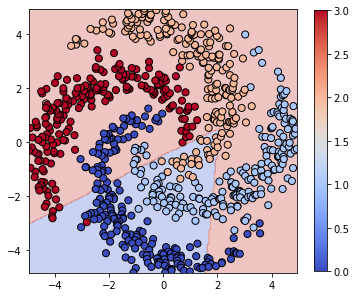

In [59]:
nn = NN_MultiLayerPerceptron(m=[2, 2, 2], 
                            eta=.01,
                            active_func='relu')
# nn = NN_MultiLayerPerceptron(m=[2, 50, 50, 50, 50, 50, 6], 
#                             eta=.01,
#                             active_func='relu')
nn.learn(X, z, n_learns=5000)

mx, my = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 200),
    np.linspace(X[:,1].min(), X[:,1].max(), 200)
)
mX = np.array([mx.ravel(), my.ravel()]).T
mz = nn.predict(mX).reshape(200, -1)

plt.figure(figsize=(6,6 ))
plt.axes(aspect=1, 
         xlim=(X[:,0].min(), X[:,0].max()),
        ylim=(X[:,1].min(), X[:,1].max())
        )
cm = 'coolwarm'
plt.contourf(mx, my, mz, cmap=cm, alpha=.3)
plt.scatter(X[:,0], X[:,1], 50, c=z, edgecolor='k', cmap=cm)

plt.colorbar(shrink=.8)
plt.show()

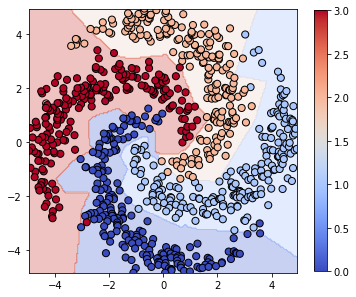

In [62]:
nn = NN_MultiLayerPerceptron(m=[2, 8, 8, 8, 4], 
                            eta=.01,
                            active_func='relu')
# nn = NN_MultiLayerPerceptron(m=[2, 50, 50, 50, 50, 50, 6], 
#                             eta=.01,
#                             active_func='relu')
nn.learn(X, z, n_learns=5000)

mx, my = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 200),
    np.linspace(X[:,1].min(), X[:,1].max(), 200)
)
mX = np.array([mx.ravel(), my.ravel()]).T
mz = nn.predict(mX).reshape(200, -1)

plt.figure(figsize=(6,6 ))
plt.axes(aspect=1, 
         xlim=(X[:,0].min(), X[:,0].max()),
        ylim=(X[:,1].min(), X[:,1].max())
        )
cm = 'coolwarm'
plt.contourf(mx, my, mz, cmap=cm, alpha=.3)
plt.scatter(X[:,0], X[:,1], 50, c=z, edgecolor='k', cmap=cm)

plt.colorbar(shrink=.8)
plt.show()

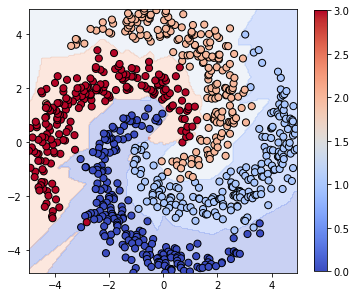

In [64]:
nn = NN_MultiLayerPerceptron(m=[2, 20, 20, 20, 20, 5], 
                            eta=.01,
                            active_func='relu')
# nn = NN_MultiLayerPerceptron(m=[2, 50, 50, 50, 50, 50, 6], 
#                             eta=.01,
#                             active_func='relu')
nn.learn(X, z, n_learns=5000)

mx, my = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 200),
    np.linspace(X[:,1].min(), X[:,1].max(), 200)
)
mX = np.array([mx.ravel(), my.ravel()]).T
mz = nn.predict(mX).reshape(200, -1)

plt.figure(figsize=(6,6 ))
plt.axes(aspect=1, 
         xlim=(X[:,0].min(), X[:,0].max()),
        ylim=(X[:,1].min(), X[:,1].max())
        )
cm = 'coolwarm'
plt.contourf(mx, my, mz, cmap=cm, alpha=.3)
plt.scatter(X[:,0], X[:,1], 50, c=z, edgecolor='k', cmap=cm)

plt.colorbar(shrink=.8)
plt.show()

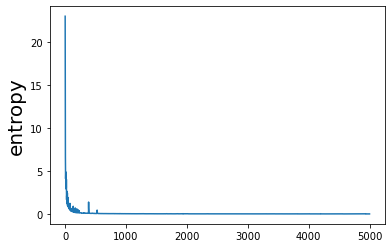

In [66]:
plt.plot(nn.entropy)
plt.ylabel('entropy', size=20)
plt.show()